# Nucleotide level interpretation of model at DNase HS sites

1. Comparison to SHARPR
2. Overlap with SiPhy conserved regions
3. Overlap with CENTIPEDE motifs
4. Average activities at motif instances, comparing cell types.

In [2]:
import numpy as np
from glob import glob
import gzip
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [38]:
def quantile_plot(data_pairs, quantiles = 5000):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    i = 0
    while avg_activity[i] < 0: i += 1
    rho, pval = spearmanr(avg_activity[i:], avg_score[i:])
    print rho, pval
    plt.scatter(avg_activity, avg_score, s = 3, lw =0)
    plt.show()

# Load in importance scores

In [22]:
deep = {} # chrom -> position -> score
files = glob('/mnt/dnase/hepg2_deeplift_20000.*')
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep:
                deep[chrom] = {}
            deep[chrom][int(pos)] = float(score)

# Comparison to SHARPR

In [13]:
# Loads in SHARPR activity scores
sharpr = {}
for promoter in ('minP',):
    for cell_type in ('HEPG2',):
        experiment_key = (promoter, cell_type)
        sharpr[experiment_key] = {}
        with open("../../data/sharpr_scores/wig/{}_{}.wig".format(promoter, cell_type)) as wig:
            for line in wig:
                if line[0] == '#': continue
                chrom, start, end, score = line.strip().split()
                start, end = int(start), int(end)
                score = float(score)
                if end - start > 1: continue
                if chrom not in sharpr[experiment_key]: sharpr[experiment_key][chrom] = {}
                for pos in range(start, end):
                    assert pos not in sharpr[experiment_key][chrom]
                    sharpr[experiment_key][chrom][pos] = score
sharpr = sharpr[sharpr.keys()[0]]

5104291
0.123138371117 2.40680612244e-261


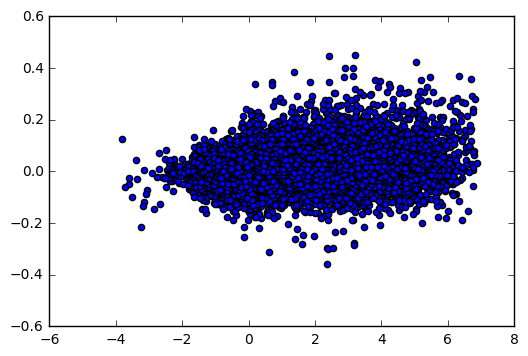

0.44663773728 1.76417331028e-170


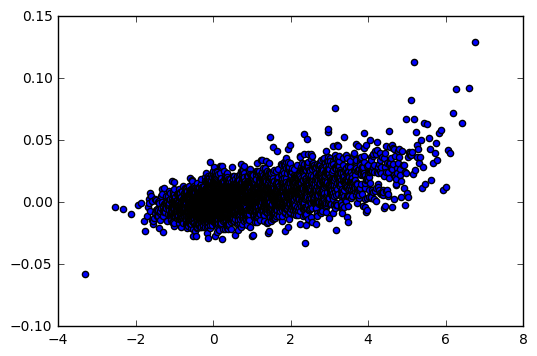

In [31]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
s, d = [], []
pairs = []
missing = 0
for chrom, positions in deep.items():
    for pos, score in positions.items():
        try:
            s += [sharpr[chrom][int(pos)]]
            d += [score]
            pairs += [(s[-1], d[-1])]
        except KeyError:
            missing += 1
print missing
rho, pval = spearmanr(s, d)
print rho, pval
plt.scatter(s, d)
#plt.plot(np.unique(s), np.poly1d(np.polyfit(s, d, 1))(np.unique(s)), c='r', linewidth=3)
plt.show()
quantile_plot(pairs, 5000)

0.123138371117 2.40680612244e-261


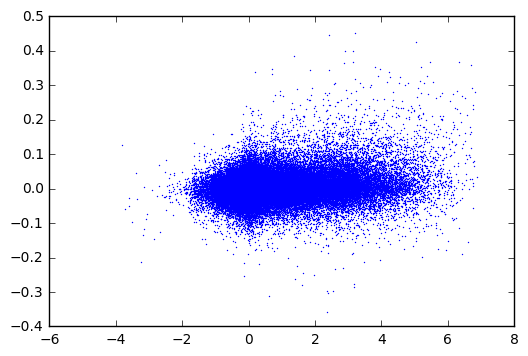

0.44663773728 1.76417331028e-170


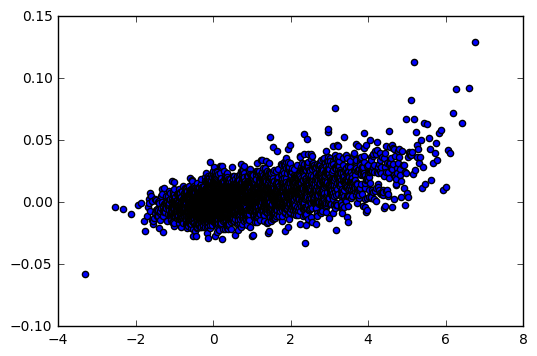

In [33]:
rho, pval = spearmanr(s, d)
print rho, pval
plt.scatter(s, d, lw = 0, s = 1)
#plt.plot(np.unique(s), np.poly1d(np.polyfit(s, d, 1))(np.unique(s)), c='r', linewidth=3)
plt.show()
quantile_plot(pairs, 5000)

# SiPhy Conservation

In [28]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with gzip.open('../../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt.gz') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in deep: continue
        if chrom not in si_phi: si_phi[chrom] = {}
        if (start not in deep[chrom]
            and end not in deep[chrom]): continue
        for pos in range(start, end):
            si_phi[chrom][pos] = 1

In [29]:
deep_conserve = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        if chrom == 'chrY': continue
        deep_conserve.append((score, si_phi[chrom][pos] if pos in si_phi[chrom] else 0))

0.691531203307 0.0


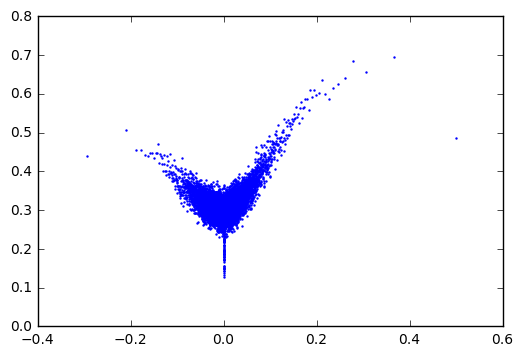

In [40]:
quantile_plot(deep_conserve, 10000)

# Comparison to CENTIPEDE motifs

In [10]:
hepG2_centipede = {}
with gzip.open('../../data/centipede/HEPG2_liftover.bed.gz') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end, motif = line.strip().split()[:4]
        start, end = int(start), int(end)
        if chrom not in hepG2_centipede: hepG2_centipede[chrom] = {}
        for pos in range(start, end):
            hepG2_centipede[chrom][pos] = motif

In [23]:
deep_centipede = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        motif = 1 if pos in hepG2_centipede[chrom] else 0
        deep_centipede.append((score, motif))

In [24]:
len(deep_centipede)

5182351

0.795680922597 0.0


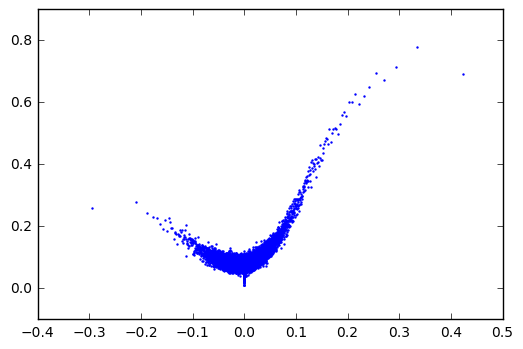

In [39]:
quantile_plot(deep_centipede, 10000)

In [42]:
encode = {}
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if chrom not in deep: continue
        if start not in deep[chrom]: continue
        for pos in range(start, end):
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)

In [46]:
deep_encode = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        if chrom == 'chrY': continue
        motif = 1 if pos in encode[chrom] else 0
        deep_encode.append((score, motif))

0.689084058577 0.0


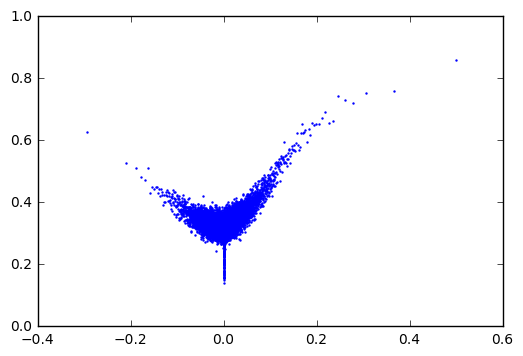

In [47]:
quantile_plot(deep_encode, 10000)

# Differential motif analysis

Will need to rerun deeplift on k562 promoter! Probably should use minP....

In [113]:
deep_k562 = {} # chrom -> position -> score
files = glob('/mnt/dnase/hepg2_deeplift_1_20000.*')
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep_k562:
                deep_k562[chrom] = {}
            deep_k562[chrom][int(pos)] = float(score)

In [118]:
k562_encode = {}
hepg2_encode = {}

for chrom, positions in deep.items():
    if chrom == 'chrY': continue
    for pos, score in positions.items():
        if pos in encode[chrom]:
            for motif in encode[chrom][pos]:
                if not motif in k562_encode:
                    k562_encode[motif] = []
                    hepg2_encode[motif] = []
                k562_encode[motif]  += [deep_k562[chrom][pos]]
                hepg2_encode[motif] += [score]

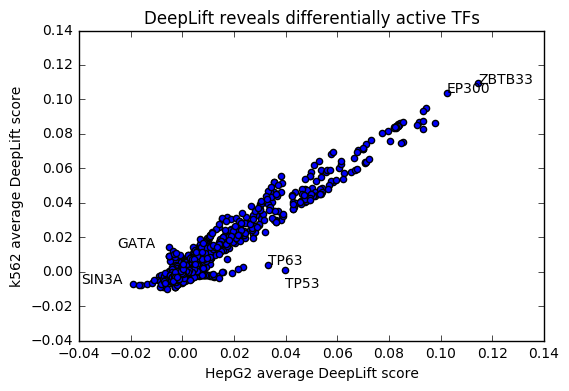

In [152]:
hepG2, k562, names = [], [], []

for motif, k in k562_encode.items():
    h = hepg2_encode[motif]
    hepG2 += [sum(h) / float(len(h))]
    k562  += [sum(k) / float(len(k))]
    names += [motif.split('_')[0]]
    
fig, ax = plt.subplots()
ax.scatter(hepG2, k562)

for i, txt in enumerate(names):
    if hepG2[i] > .03 and k562[i] < 0.01:
        shift = 0
        if txt == 'TP53': shift = -.01
        ax.annotate(txt, (hepG2[i], k562[i] + shift))
    if hepG2[i] > .1 and k562[i] > 0.1:
        ax.annotate(txt, (hepG2[i], k562[i]))  
    if hepG2[i] <  - .017 and k562[i] <  0:
        ax.annotate(txt, (hepG2[i] - .02, k562[i]))
        
    if hepG2[i] < 0 and k562[i] >  .013:
        ax.annotate(txt, (hepG2[i] - .02, k562[i]))

plt.title('DeepLift reveals differentially active TFs')
plt.xlabel('HepG2 average DeepLift score')
plt.ylabel('k562 average DeepLift score')
plt.show()

# Search for missing motifs

What is the plan??



In [66]:
unexplained = []
for chrom, positions in deep.items():
    for pos, score in positions.items():
        if chrom == 'chrY': continue
        if score > 0.15 and not any(pos + i not in encode[chrom] for i in range(-10, 10)):
            found = False
            for c, start, end in unexplained:
                if c == chrom and start < pos < end:
                    found = True
            if not found:
                unexplained += [(chrom, pos-10, pos + 10)]

In [67]:
out = open('unexplained.bed', 'w')
for chrom, start, end in unexplained:
    out.write(chrom + '\t' +  str(start) + '\t' + str(end) + '\n')

In [108]:
sites = open('motif_4_fasta.txt')
counts = np.zeros((80,))
num = 0
for line in sites:
    if line[0] != '>': continue
    chrom, rest = line[1:].strip().split(':')
    start, rest = rest.split('-')
    end = rest.split('_')[0]
    offset = rest.split('=')[-1][1]
    num += 1
    center = (int(end) + int(start)) / 2 + int(offset)
    
    for pos in range(- 40, 40):
        counts[pos+40] += pos+center in si_phi[chrom]
        

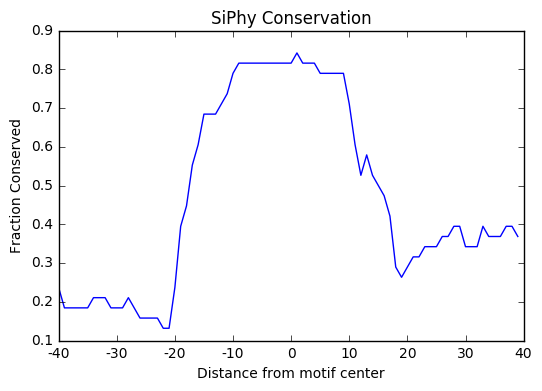

In [109]:
plt.plot(counts.T / num)
plt.title('SiPhy Conservation')
plt.xlabel('Distance from motif center')
plt.ylabel('Fraction Conserved')
plt.xticks(range(0, 81, 10), range(-40, 41, 10))
plt.show()

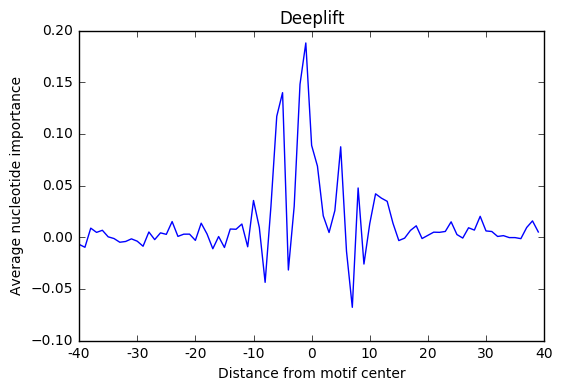

In [110]:
sites = open('motif_4_fasta.txt')
counts = np.zeros((80,))
num = 0
for line in sites:
    if line[0] != '>': continue
    chrom, rest = line[1:].strip().split(':')
    start, rest = rest.split('-')
    end = rest.split('_')[0]
    offset = rest.split('=')[-1][1]
    
    center = (int(end) + int(start)) / 2 + int(offset)
    num += 1
    for pos in range(- 40, 40):
        counts[pos+40] += deep[chrom][pos+center] if pos+center in deep[chrom] else 0
plt.plot(counts.T / num)
plt.title('Deeplift')
plt.xlabel('Distance from motif center')
plt.ylabel('Average nucleotide importance')
plt.xticks(range(0, 81, 10), range(-40, 41, 10))
plt.show()

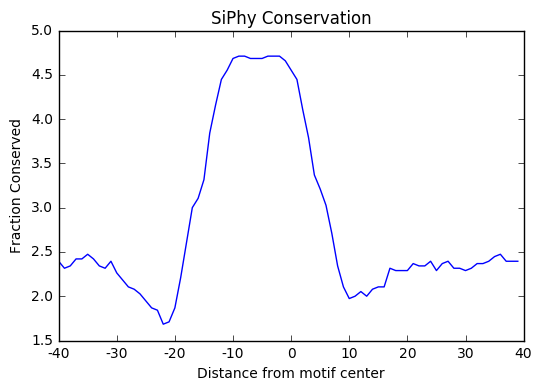

In [111]:
# NRF
sites = open('motif_1_fasta.txt')
counts = np.zeros((80,))
for line in sites:
    if line[0] != '>': continue
    chrom, rest = line[1:].strip().split(':')
    start, rest = rest.split('-')
    end = rest.split('_')[0]
    offset = rest.split('=')[-1][1]
    
    center = (int(end) + int(start)) / 2 + int(offset)
    
    for pos in range(- 40, 40):
        counts[pos+40] += pos+center in si_phi[chrom]
plt.plot(counts.T / num)
plt.title('SiPhy Conservation')
plt.xlabel('Distance from motif center')
plt.ylabel('Fraction Conserved')
plt.xticks(range(0, 81, 10), range(-40, 41, 10))
plt.show()

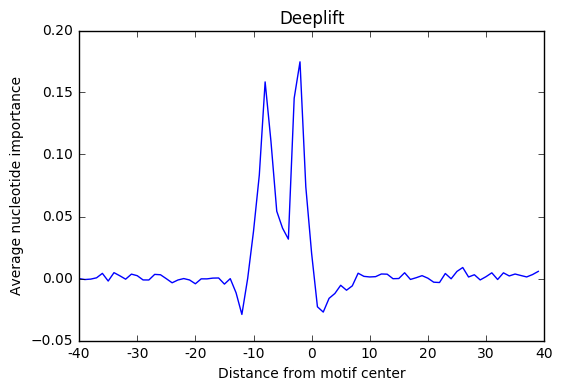

In [112]:
sites = open('motif_1_fasta.txt')
counts = np.zeros((80,))
num = 0
for line in sites:
    if line[0] != '>': continue
    chrom, rest = line[1:].strip().split(':')
    start, rest = rest.split('-')
    end = rest.split('_')[0]
    offset = rest.split('=')[-1][1]
    
    center = (int(end) + int(start)) / 2 + int(offset)
    num += 1
    for pos in range(- 40, 40):
        counts[pos+40] += deep[chrom][pos+center] if pos+center in deep[chrom] else 0
plt.plot(counts.T / num)
plt.title('Deeplift')
plt.xlabel('Distance from motif center')
plt.ylabel('Average nucleotide importance')
plt.xticks(range(0, 81, 10), range(-40, 41, 10))
plt.show()